In [1]:
from utils import *

C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
GAME = 'CartPole-v1'
env = gym.make(GAME)
S, A = env.observation_space.shape[0], env.action_space.n
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Box(4,)
Discrete(2)
(-inf, inf)


In [3]:
class Model(tf.keras.Model):
    def __init__(self, S, A):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(50, 'relu')
        self.W2 = tf.keras.layers.Dense(50, 'relu')
        self.V = tf.keras.layers.Dense(1)
        self.P = tf.keras.layers.Dense(A, 'softmax')
        self.build((None,S))
    
    def call(self, x):
        x = self.W1(x)
        x = self.W2(x)
        return self.P(x), self.V(x)
    
create_nn = lambda S,A: Model(S,A)

In [4]:
class Agent():
    def __init__(self, num_states, num_actions, lr, gamma=0.99):
        self.S, self.A = num_states, num_actions
        self.optimizer = tf.optimizers.Adam(lr)
        self.y = gamma
        self.nn = create_nn(S,A)
        
    def first_step(self, s, sdict): # [S]
        a = np.random.randint(self.A) # [] (random move)
        self.E = []
        self.s, self.a = s, a # save prev state + action
        return a
        
    def step(self, r, s, sdict): # [], [S]
        # append tuple to experience replay
        self.E.append([self.s, self.a, r, s, False]) # s, a, r, s', done(bool)
        pi, v = self.nn(s[None,:]) # [1,A]
        a = tf.random.categorical(tf.math.log(pi), num_samples=1) # [1,1]
        a = int(a[0,0]) # []
        self.s, self.a = s, a # save previous state, action
        return a
    
    def last_step(self, r, sdict):
        self.E.append([self.s, self.a, r, None, True]) # s, a, r, s', done
        # need squeeze, because self.s/a is [1,S/A], so S=[e,1,S/A] -> [e,S/A]
        S = np.squeeze(np_map(lambda x: x[0], self.E)) # [e,S], where e - number steps in episode
        if S.ndim == 1: S = S[None,:] # for cases if example size is 1 and squeezed
        A = np.squeeze(np_map(lambda x: x[1], self.E)) # [e]
        A = one_hot(A.astype(int), C=self.A) # [e,A]
        # prerprocess reward
        R = np_map(lambda x: x[2], self.E) # [e]
        G = discount_rewards(R, self.y, normalize=True)[:,None] # [e,1]
        # train nn for 1 epoch
        with tf.GradientTape() as tape:
            A_hat, V_hat = self.nn(S) # [e,A]
            A_hat = tf.clip_by_value(A_hat, 1e-6, 1-1e-6) # clip tf.log(0)
            Adv = G - V_hat # [e,A] (advantage)
            policy_loss = -A * tf.math.log(A_hat) * tf.stop_gradient(Adv) # [e,A]
            value_loss = Adv**2 # [e,A]
            each_loss = policy_loss + value_loss # [e,A]
            loss = tf.reduce_mean(tf.reduce_sum(each_loss, axis=-1)) # avg of all examples
        # calc + update gradients
        nn_vars = self.nn.trainable_variables
        grads = tape.gradient(loss, nn_vars)
        self.optimizer.apply_gradients(zip(grads, nn_vars))

In [5]:
agent_fn = lambda S,A,env_fn=None: Agent(S, A, lr=1e-2, gamma=0.99)

In [6]:
exp = Experiment(env, agent_fn(S,A))
df = exp.run(500, 1, name='')

KeyboardInterrupt: 

In [ ]:
test_agent_on_simple_games(agent_fn, 'ActorCritic', game_dict={'CartPole-v1':500})

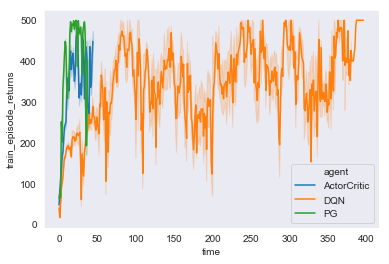

In [7]:
df = load_my_benchmark('CartPole-v1')
plot_df(df, x='time', rolling_mean=5, bins=2)